# Imports

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import clear_output
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [2]:
def plot_avg(boro=None, cam_id=None):
    # -- Select relevant cameras.
    if boro != None:
        cams_ = cams[(cams.boro == boro) & (cams.people == 1.)].cam_id.unique()
    if cam_id != None:
        cams_ = [cam_id]
        
    df_ = df[df.cam_id.isin(cams_)]
    boro_wd = groupby_subset(df_[(df_.index.weekday < 5) & 
                                 ~((df_.index.isin(df_["20170704"].index)) | 
                                   (df_.index.isin(df_["20170904"].index)))])
    boro_we = groupby_subset(df_[(df_.index.weekday >= 5)])
    boro_ho = groupby_subset(df_[(df_.index.isin(df_["20170704"].index)) | 
                                 (df_.index.isin(df_["20170904"].index))])
    # -- Plot data & format plot.
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    for data, cc, lab in [(boro_wd["count"], "k", "Weekday"), 
                          (boro_we["count"], "b", "Weekends"), 
                          (boro_ho["count"], "r", "Holidays")]:
        data.plot(ax=ax, color=cc, alpha=0.6, label=lab)
    ax.set_xlabel("Hour (H:M)", fontsize=12)
    ax.set_ylabel("Average Pedestrian Count", fontsize=12)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.tick_params(axis="both", which="both", labelsize=12)
    ax.grid(True, which="both")
    ax.legend(ncol=3, fontsize=12)

    if boro != None:
        ax.set_title("Average Pedestrian Counts in {}".format(boro), fontsize=16)
    if cam_id != None:
        ax.set_title("Average Pedestrian Counts at Camera {}".format(cam_id), fontsize=16)
    
def reformat_dur(df, dur="15min"):
    # -- Convert datetime to rounded string (e.g., 09:00).
    nn = time.time()
    df["t"] = (df.index.round(dur).values).astype(str)
    df["t"] = df.t.str[11:16]
    print "Time (str) formatting complete ({0:.2f}s)".format(time.time() - nn)

def groupby_subset(df, cams=False, standardize=False):
    # -- Groupby by rounded string then format columns & dummy index.
    nn = time.time()
    if cams:
        tmp = df.groupby(["cam_id", "t"]).mean().unstack(level=0)
        tmp.columns = tmp.columns.droplevel()
    else:
        tmp = pd.DataFrame(df.groupby(["t"])["count"].mean())
    tmp.index = [pd.to_datetime("9-9-99 " + x) for x in tmp.index]
    
    if standardize:
        tmp = (tmp - tmp.mean()) / tmp.std()
    return tmp

# Load Data

In [5]:
df = pd.read_feather("../data/results/hadive-data.feather").set_index("date")
df = df[~df.index.isnull()]
reformat_dur(df)
df.head(2)

Time (str) formatting complete (35.64s)


,cam_id,count,t
date,,,
2017-06-27 20:09:22,368,1,20:15
2017-06-27 20:09:23,360,1,20:15


In [6]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0,1,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1,0,Queens,11367


# Cameras Average (Borough)

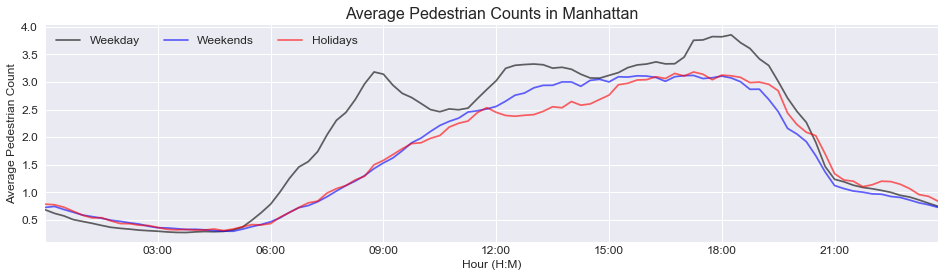

In [7]:
plot_avg(boro="Manhattan")

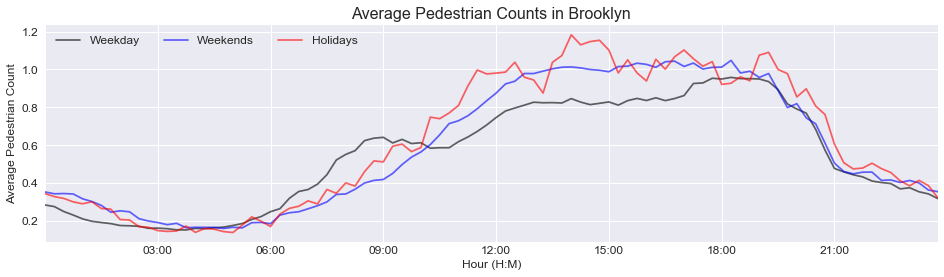

In [8]:
plot_avg(boro="Brooklyn")

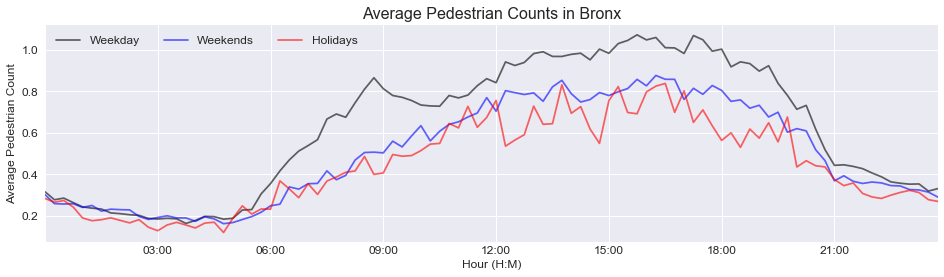

In [9]:
plot_avg(boro="Bronx")

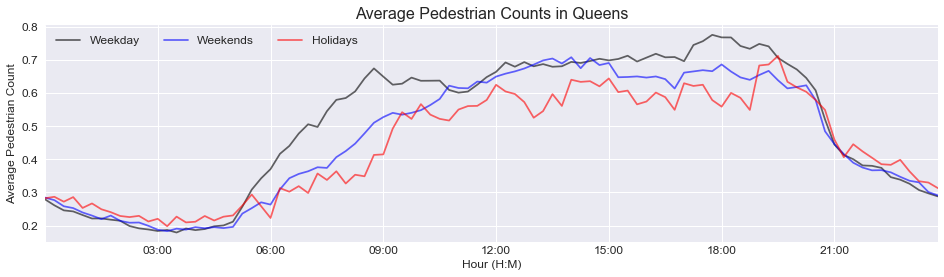

In [10]:
plot_avg(boro="Queens")

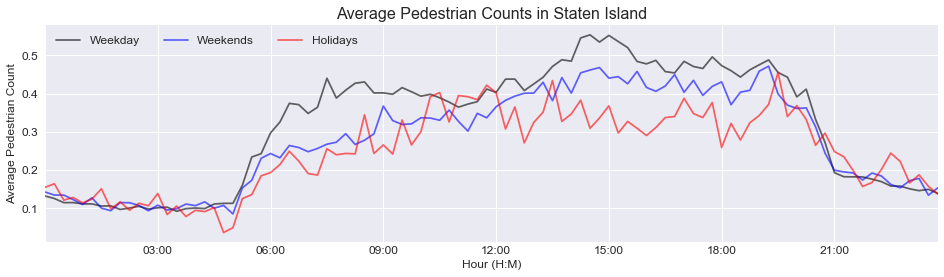

In [11]:
plot_avg(boro="Staten Island")

# Camera Average

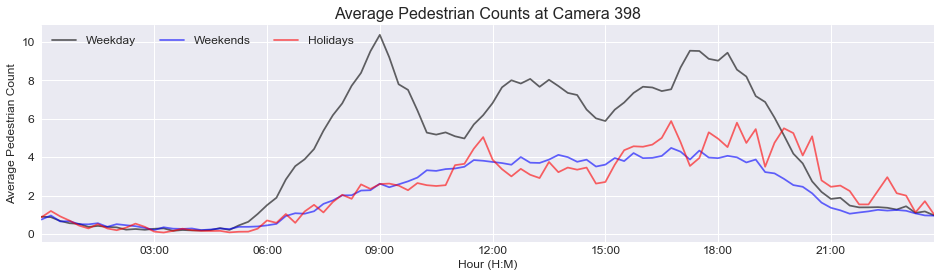

In [12]:
plot_avg(cam_id=398)